# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the task of POS tagging.

<center>
    <img src="images/pos_tagging.png" alt="POS tagging" />
</center>

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

In [ ]:
# system packages
from itertools import groupby
from pathlib import Path
import shutil
import urllib
import zipfile
import sys
import random

# data and numerical management packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# useful during debugging (progress bars)
from tqdm import tqdm

# typing
from typing import List, Callable, Dict

# machine learning
import tensorflow as tf
import keras

# Reproducibility
seed = 23

random.seed(seed)
np.random.seed(seed)
keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()

In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 2560,
        'height': 1440,
        'scroll': True,
})

{'width': 2560, 'height': 1440, 'scroll': True}

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

In [ ]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    zip_ref = zipfile.ZipFile(download_path, 'r')
    zip_ref.extractall(extract_path)
    zip_ref.close()
    print("Extraction completed!")

In [ ]:
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_tar_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_tar_path.exists():
    download_dataset(dataset_tar_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_tar_path, dataset_folder)

Current work directory: /content


In [ ]:
# Establish path to each split documents
folder = dataset_folder.joinpath(dataset_name)

train_files = [f"{folder}/wsj_{f_index:04}.dp" for f_index in range(1, 100 + 1)]
valid_files = [f"{folder}/wsj_{f_index:04}.dp" for f_index in range(101, 150 + 1)]
test_files = [f"{folder}/wsj_{f_index:04}.dp" for f_index in range(151, 199 + 1)]

splits = [train_files, valid_files, test_files]

In [ ]:
datarows = []

for split in splits:

  dataframe_rows = []

  for file_path in split:
    with open(file_path, mode='r', encoding='utf-8') as text_file:

      lines = text_file.read().splitlines()
      doc_sentences = [list(group) for key, group in groupby(lines, lambda x: x != '') if key]

      for sentence in doc_sentences:
        dataframe_rows.append({
            "sequence": [el.split("\t")[0] for el in sentence],
            "pos_tags": [el.split("\t")[1] for el in sentence]
        })

  datarows.append(dataframe_rows)

In [ ]:
# transform the list of rows in a proper dataframe
dataset = {
    "train": pd.DataFrame(datarows[0], columns=["sequence","pos_tags"]),
    "valid": pd.DataFrame(datarows[1], columns=["sequence","pos_tags"]),
    "test": pd.DataFrame(datarows[2], columns=["sequence","pos_tags"])
}

In [ ]:
print(f"Train split: {dataset['train'].shape}")
print(f"Validation split: {dataset['valid'].shape}")
print(f"Test split: {dataset['test'].shape}")

print(f"Dataset columns: {dataset['train'].columns.values}")

POS_TAGS = dataset['train']['pos_tags'].explode()
pos_tags_count = POS_TAGS.value_counts()
print(f"Classes distribution:\n{pos_tags_count}")

print(f"Some examples:")
dataset['train'].head()

Train split: (1963, 2)
Validation split: (1299, 2)
Test split: (652, 2)
Dataset columns: ['sequence' 'pos_tags']
Classes distribution:
NN       6270
NNP      5202
IN       4952
DT       4076
NNS      3004
JJ       2992
,        2571
.        1959
VBD      1548
RB       1490
CD       1439
VB       1195
CC       1141
VBZ      1133
VBN      1031
TO       1028
PRP       954
VBG       763
VBP       727
MD        413
PRP$      409
``        409
POS       403
''        399
$         342
:         293
WDT       204
JJR       157
WP        141
RP        140
NNPS       95
JJS        93
WRB        92
RBR        86
-RRB-      55
-LRB-      52
EX         49
RBS        19
LS         10
PDT         9
WP$         6
FW          2
UH          1
SYM         1
#           1
Name: pos_tags, dtype: int64
Some examples:


,sequence,pos_tags
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

###Preprocessing
Let's do some pre-processing first before building the vocabulary.

In [ ]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()

In [ ]:
from functools import reduce

PREPROCESSING_PIPELINE = [lower]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [ ]:
print('Pre-processing text...')
df_old = dataset.copy()
print()
print(f"[Debug] Before:\n{df_old['train'].sequence.iloc[:10]}")
print()

# Replace each sentence with its pre-processed version
for split in dataset.values():
  for (i, seq) in enumerate(split.sequence):
    seqs = [text_prepare(txt) for txt in seq]
    split.sequence.iloc[i] = seqs

print(f"[Debug] After:\n{dataset['train'].sequence.iloc[:10]}")
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
0    [Pierre, Vinken, ,, 61, years, old, ,, will, j...
1    [Mr., Vinken, is, chairman, of, Elsevier, N.V....
2    [Rudolph, Agnew, ,, 55, years, old, and, forme...
3    [A, form, of, asbestos, once, used, to, make, ...
4    [The, asbestos, fiber, ,, crocidolite, ,, is, ...
5    [Lorillard, Inc., ,, the, unit, of, New, York-...
6    [Although, preliminary, findings, were, report...
7    [A, Lorillard, spokewoman, said, ,, ``, This, ...
8    [We, 're, talking, about, years, ago, before, ...
9    [There, is, no, asbestos, in, our, products, n...
Name: sequence, dtype: object

[Debug] After:
0    [pierre, vinken, ,, 61, years, old, ,, will, j...
1    [mr., vinken, is, chairman, of, elsevier, n.v....
2    [rudolph, agnew, ,, 55, years, old, and, forme...
3    [a, form, of, asbestos, once, used, to, make, ...
4    [the, asbestos, fiber, ,, crocidolite, ,, is, ...
5    [lorillard, inc., ,, the, unit, of, new, york-...
6    [although, preliminary, findi

## Load GloVe
We define the function used to load the pre-trained embedding model and execute it to load the model into memory.

In [ ]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [ ]:
# PARAMETERS
model_type="glove"
embedding_dimension=50

# Load the embedding model into memory
embedding_model = load_embedding_model(model_type=model_type,
                                       embedding_dimension=embedding_dimension)

## Build the vocabulary
We define the function that builds the vocabulary based on our training set and perform some checking on it. Moreover, we check the OOV terms to see if this could be a problem.

In [ ]:
from collections import OrderedDict

def build_vocabulary(df: pd.DataFrame, SPECIAL_TOKENS: list) -> (Dict[int, str],
                                                                Dict[str, int],
                                                                List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param
      - df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
      - SPECIAL_TOKENS: list of special tokens to be added to the vocabulary
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    curr_idx = 0

    # Add special tokens to the vocabulary
    for token in SPECIAL_TOKENS:
      word_to_idx[token] = curr_idx
      idx_to_word[curr_idx] = token
      curr_idx += 1

    # Add the rest of the tokens to the vocabulary
    for sentence in tqdm(df.sequence.values):
        for token in sentence:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [ ]:
SPECIAL_TOKENS = ['<PAD>', '<UNK>']

# BUILD THE VOCABULARY
idx_to_word, word_to_idx, word_listing = build_vocabulary(dataset['train'], SPECIAL_TOKENS)
print()
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')
print(f'[Debug] Some words: {[(idx_to_word[idx], idx) for idx in np.arange(10)]}')

100%|██████████| 1963/1963 [00:00<00:00, 64891.38it/s]


[Debug] Index -> Word vocabulary size: 7406
[Debug] Word -> Index vocabulary size: 7406
[Debug] Some words: [('<PAD>', 0), ('<UNK>', 1), ('pierre', 2), ('vinken', 3), (',', 4), ('61', 5), ('years', 6), ('old', 7), ('will', 8), ('join', 9)]


In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
# CHECKING ON THE OOV TERMS
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")
print(oov_terms)

Total OOV terms: 361 (4.87%)
['light-truck', 'eight-count', 'junk-bond', 'small-company', 'subindustry', '100,980', '2,303,328', 'wheeland', '446.62', 'automotive-parts', 'pathlogy', '127.03', '2645.90', '1\\/4', 'nekoosa', 'moleculon', 'derel', 'higher-salaried', 'c.j.b.', 'pro-forma', 'built-from-kit', '1.457', 'sub-segments', 'equal-opportunity', 'one-yen', 'sticker-shock', 'trading-company', 'old-house', 'program-trading', 'malizia', 'nissho-iwai', 'amphobiles', 'nesb', 'sport-utility', 'machine-gun-toting', 'flightiness', 'autions', 'post-hearing', 'anti-abortionists', 'mouth-up', 'more-efficient', 'intellectual-property', 'chong-sik', 'summer\\/winter', 'beer-belly', 'iran\\/contra', 'page-one', 'bermuda-based', 'sometimes-tawdry', 'yen-support', 'training-wage', 'test-preparation', 'northy', 'six-bottle', 'trettien', 'durable-goods', 'pianist-comedian', 'ariail', '143.80', 'thin-lipped', 'cash-rich', 'glenham', 'c-90', 'language-housekeeper', 'marketing-communications', 'buttone

## Build the embedding matrix
We define the function used to build the embedding matrix based on our pre-trained embedding model and our vocabulary.

In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            # Look for the embedding vector of the word in GloVe
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            # If the word is OOV then assign a random uniform vector of the same dimension
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
# Testing
embedding_dimension = 50
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, len(word_to_idx), oov_terms)
print()
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 7406/7406 [00:00<00:00, 174383.96it/s]


Embedding matrix shape: (7406, 50)


## Vectorization of the data

In [ ]:
# Determine the possible labels
POS_TAGS = np.unique(POS_TAGS)

# Add padding id to the tags
POS_TAGS = np.insert(POS_TAGS, 0, 'PAD')

# Assign an id for each label
CATEGORIES = {tag: i for (i, tag) in enumerate(POS_TAGS)}
print(CATEGORIES)

{'PAD': 0, '#': 1, '$': 2, "''": 3, ',': 4, '-LRB-': 5, '-RRB-': 6, '.': 7, ':': 8, 'CC': 9, 'CD': 10, 'DT': 11, 'EX': 12, 'FW': 13, 'IN': 14, 'JJ': 15, 'JJR': 16, 'JJS': 17, 'LS': 18, 'MD': 19, 'NN': 20, 'NNP': 21, 'NNPS': 22, 'NNS': 23, 'PDT': 24, 'POS': 25, 'PRP': 26, 'PRP$': 27, 'RB': 28, 'RBR': 29, 'RBS': 30, 'RP': 31, 'SYM': 32, 'TO': 33, 'UH': 34, 'VB': 35, 'VBD': 36, 'VBG': 37, 'VBN': 38, 'VBP': 39, 'VBZ': 40, 'WDT': 41, 'WP': 42, 'WP$': 43, 'WRB': 44, '``': 45}


In [ ]:
def vectorize_df(df: pd.DataFrame) -> pd.DataFrame:
  # Create a copy of the dataset
  df_copy = df.copy()

  for (i, record) in df_copy.iterrows():
    # New row data
    row = {
        'sequence': [word_to_idx[token] if token in word_listing else 1 for token in record['sequence']],
        'pos_tags': [CATEGORIES[tag] for tag in record['pos_tags']]
    }

    # Replace row at index i with the new row data
    df_copy.loc[i] = row

  return df_copy

In [ ]:
print('Pre-processing text...')
vect_dataset = {}
print()
print(f"[Debug] Before:\n{df_old['valid'][:3]}")
print()

for split in dataset:
  vect_dataset[split] = vectorize_df(dataset[split])

print(f"[Debug] After:\n{vect_dataset['valid'][:3]}")
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
                                            sequence  \
0  [a, house-senate, conference, approved, major,...   
1  [for, the, agency, for, international, develop...   
2  [the, conference, approved, at, least, $, 55, ...   

                                            pos_tags  
0  [DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...  
1  [IN, DT, NNP, IN, NNP, NNP, ,, NNS, VBD, $, CD...  
2  [DT, NN, VBD, IN, JJS, $, CD, CD, IN, JJ, NN, ...  

[Debug] After:
                                            sequence  \
0  [13, 1, 2032, 526, 1770, 1, 22, 13, 6099, 177,...   
1  [177, 10, 290, 177, 547, 1346, 4, 1, 526, 461,...   
2  [10, 2032, 526, 154, 1368, 461, 30, 536, 97, 1...   

                                            pos_tags  
0  [11, 21, 20, 36, 15, 23, 14, 11, 20, 14, 16, 1...  
1  [14, 11, 21, 14, 21, 21, 4, 23, 36, 2, 10, 10,...  
2  [11, 20, 36, 14, 17, 2, 10, 10, 14, 15, 20, 9,...  

Pre-processing completed!


In [ ]:
vect_dataset['valid'].head()

,sequence,pos_tags
0,"[13, 1, 2032, 526, 1770, 1, 22, 13, 6099, 177,...","[11, 21, 20, 36, 15, 23, 14, 11, 20, 14, 16, 1..."
1,"[177, 10, 290, 177, 547, 1346, 4, 1, 526, 461,...","[14, 11, 21, 14, 21, 21, 4, 23, 36, 2, 10, 10,..."
2,"[10, 2032, 526, 154, 1368, 461, 30, 536, 97, 1...","[11, 20, 36, 14, 17, 2, 10, 10, 14, 15, 20, 9,..."
3,"[10, 1627, 146, 2942, 1, 74, 10, 1770, 5925, 2...","[11, 20, 14, 21, 40, 14, 11, 15, 23, 37, 14, 1..."
4,"[349, 4535, 2513, 153, 1023, 13, 4868, 97, 1, ...","[11, 15, 23, 39, 28, 11, 20, 14, 37, 11, 21, 2..."


## Padding data

In [ ]:
MAX_LEN = max([len(row[1]['sequence']) for row in vect_dataset['train'].iterrows()])
print(f"Maximum sequence length in the training set: {MAX_LEN}")

Maximum sequence length in the training set: 249


In [ ]:
def pad_df(df: pd.DataFrame, pad_len: int) -> pd.DataFrame:
  # Create a copy of the dataset
  df_copy = df.copy()

  # Pad sequences
  padded_seqs = pad_sequences(df.sequence, maxlen=pad_len, padding='post', truncating='post')
  padded_tags = pad_sequences(df.pos_tags, maxlen=pad_len, padding='post', truncating='post')
  df_copy.sequence = list(padded_seqs)
  df_copy.pos_tags = list(padded_tags)

  return df_copy

In [ ]:
from keras.preprocessing.sequence import pad_sequences

print('Pre-processing text...')
padded_dataset = {}
print()
print(f"[Debug] Before:\n{vect_dataset['valid']['sequence'][0]}")
print()

for split in dataset:
  padded_dataset[split] = pad_df(vect_dataset[split], MAX_LEN)

print(f"[Debug] After:\n{padded_dataset['valid']['sequence'][0]}")
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
[13, 1, 2032, 526, 1770, 1, 22, 13, 6099, 177, 62, 63, 461, 754, 536, 97, 834, 1623, 177, 2942, 80, 1, 486, 146, 461, 1, 536, 97, 945, 31, 4289, 1, 97, 4535, 893, 97, 1122, 22, 1, 820, 828, 31, 2046, 18]

[Debug] After:
[  13    1 2032  526 1770    1   22   13 6099  177   62   63  461  754
  536   97  834 1623  177 2942   80    1  486  146  461    1  536   97
  945   31 4289    1   97 4535  893   97 1122   22    1  820  828   31
 2046   18    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0

## Prepare the date to be fed

In [ ]:
X_train = np.vstack(padded_dataset['train']['sequence'].to_numpy())
y_train = np.vstack(padded_dataset['train']['pos_tags'].to_numpy())

X_valid = np.vstack(padded_dataset['valid']['sequence'].to_numpy())
y_valid = np.vstack(padded_dataset['valid']['pos_tags'].to_numpy())

X_test = np.vstack(padded_dataset['test']['sequence'].to_numpy())
y_test = np.vstack(padded_dataset['test']['pos_tags'].to_numpy())

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

(1963, 249)
(1963, 249)
(1299, 249)
(1299, 249)
(652, 249)
(652, 249)


# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

In [ ]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Input, TimeDistributed
import sklearn

def build_rnn(vocab_size, max_len, embedding_dim, num_labels, model_ver=None):
  # Build the embedding layer using the pre-trained embedding
  embedding_layer = Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=max_len,
    trainable=True,
    mask_zero=True
  )

  # Define the model architecture
  model = Sequential()
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

  if model_ver == 1:
    model.add(LSTM(units=64, return_sequences=True))
  elif model_ver == 2:
    model.add(TimeDistributed(Dense(len(POS_TAGS))))
  else:
    pass

  model.add(TimeDistributed(Dense(len(POS_TAGS), activation="softmax")))

  model.summary()

  return model

In [ ]:
model0 = build_rnn(len(word_to_idx),
                   MAX_LEN,
                   embedding_dimension,
                   len(POS_TAGS))

model0.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 249, 50)           370300    
                                                                 
 bidirectional (Bidirection  (None, 249, 128)          58880     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 249, 46)           5934      
 ributed)                                                        
                                                                 
Total params: 435114 (1.66 MB)
Trainable params: 435114 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model1 = build_rnn(len(word_to_idx),
                   MAX_LEN,
                   embedding_dimension,
                   len(POS_TAGS),
                   model_ver=1)

model1.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 249, 50)           370300    
                                                                 
 bidirectional_1 (Bidirecti  (None, 249, 128)          58880     
 onal)                                                           
                                                                 
 lstm_2 (LSTM)               (None, 249, 64)           49408     
                                                                 
 time_distributed_1 (TimeDi  (None, 249, 46)           2990      
 stributed)                                                      
                                                                 
Total params: 481578 (1.84 MB)
Trainable params: 481578 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2 = build_rnn(len(word_to_idx),
                        MAX_LEN,
                        embedding_dimension,
                        len(POS_TAGS),
                        model_ver=2)

model2.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 249, 50)           370300    
                                                                 
 bidirectional_2 (Bidirecti  (None, 249, 128)          58880     
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 249, 46)           5934      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 249, 46)           2162      
 stributed)                                                      
                                                                 
Total params: 437276 (1.67 MB)
Trainable params: 437276 (1.67 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

In [ ]:
from sklearn.metrics import f1_score
import re

def remove_padding(arr):
  return arr[arr!=0]

def reverse_vectorization_tags(arr):
  return np.array([list(CATEGORIES.keys())[token] for token in arr])

def remove_punctuation(arr):
    pattern = r'[^\w\s]'
    token_tags = reverse_vectorization_tags(arr)
    cleaned_tokens = []
    indexes = []
    for i in range(arr.shape[0]):
      cleaned_token = re.sub(pattern,'', token_tags[i])
      if cleaned_token!='':
        cleaned_tokens.append(cleaned_token)
      else:
        indexes.append(i)
    return np.array(cleaned_tokens), indexes

def compute_f1(y_true, y_pred):
  y_pred_class = tf.cast(tf.math.argmax(y_pred, axis=-1),"int32")
  mask = tf.cast(tf.math.not_equal(y_true, 0), 'int32')
  #print(y_pred_class*mask)
  #y_pred_unpadded,indexes_pred_unpadded = np.array(remove_punctuation(remove_padding(y_pred_class * mask)))
  y_true_unpadded,removed_indexes= remove_punctuation(remove_padding(tf.cast(y_true,'int32') * mask))
  #Remove indexes punctuations tokens in y_pred
  y_pred_unpadded = reverse_vectorization_tags(remove_padding(y_pred_class * mask).numpy())
  y_pred_unpadded= np.delete(y_pred_unpadded,removed_indexes)
  f1 = f1_score(y_true_unpadded,y_pred_unpadded,average='macro')
  return f1

def f1(y_true,y_pred):
    scores = [compute_f1(y_true[i], y_pred[i]) for i in range(y_true.shape[0])]
    return np.mean(scores)

def print_metric(model, features, labels):
  predictions = model.predict(features)
  av_score = f1(labels, predictions)
  print(f"F1 on passed set : {av_score}")

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [ ]:
hist = model0.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
62/62 [==============================] - 41s 517ms/step - loss: 2.8718 - val_loss: 2.3233
Epoch 2/10
62/62 [==============================] - 29s 462ms/step - loss: 1.7604 - val_loss: 1.3971
Epoch 3/10
62/62 [==============================] - 29s 474ms/step - loss: 1.0327 - val_loss: 0.9509
Epoch 4/10
62/62 [==============================] - 28s 461ms/step - loss: 0.6910 - val_loss: 0.7338
Epoch 5/10
62/62 [==============================] - 30s 494ms/step - loss: 0.5089 - val_loss: 0.6173
Epoch 6/10
62/62 [==============================] - 30s 486ms/step - loss: 0.4002 - val_loss: 0.5485
Epoch 7/10
62/62 [==============================] - 29s 462ms/step - loss: 0.3262 - val_loss: 0.5037
Epoch 8/10
62/62 [==============================] - 30s 493ms/step - loss: 0.2722 - val_loss: 0.4723
Epoch 9/10
62/62 [==============================] - 29s 464ms/step - loss: 0.2324 - val_loss: 0.4455
Epoch 10/10
62/62 [==============================] - 29s 465ms/step - loss: 0.1988 - val_lo

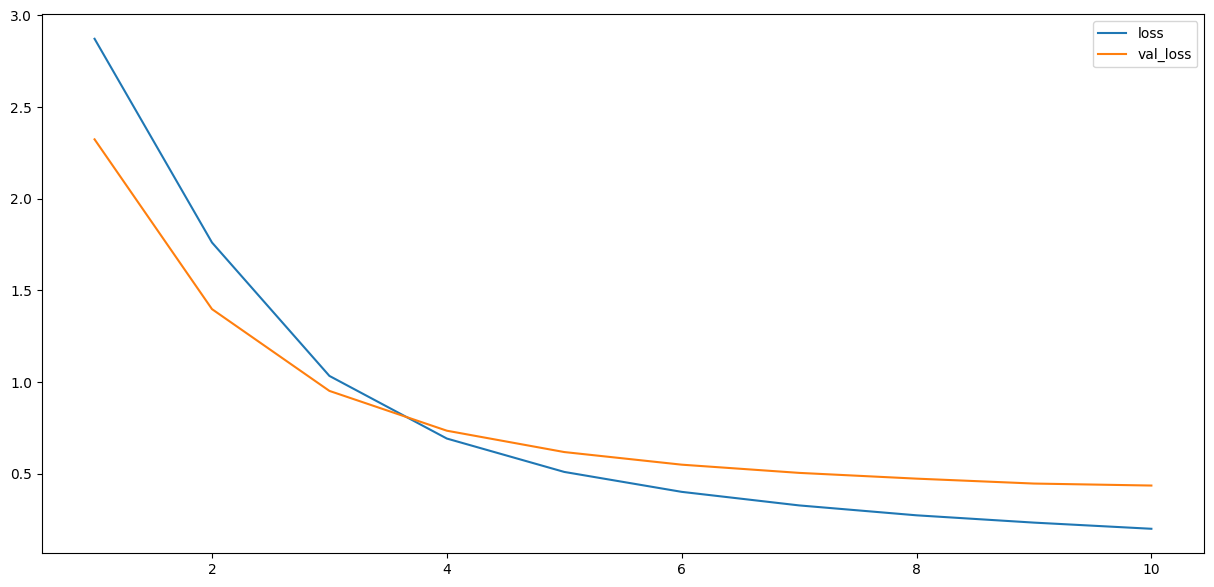

In [ ]:
n_epocs = 10
x = np.arange(1, n_epocs+1)

plt.figure(figsize=(15,7))

plt.plot(x, hist.history['loss'])
plt.plot(x, hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])

plt.show()

In [ ]:
hist = model1.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
62/62 [==============================] - 62s 780ms/step - loss: 3.0133 - val_loss: 2.6539
Epoch 2/10
62/62 [==============================] - 44s 718ms/step - loss: 2.2304 - val_loss: 1.8686
Epoch 3/10
62/62 [==============================] - 44s 715ms/step - loss: 1.4800 - val_loss: 1.3135
Epoch 4/10
62/62 [==============================] - 44s 716ms/step - loss: 1.0115 - val_loss: 0.9776
Epoch 5/10
62/62 [==============================] - 48s 780ms/step - loss: 0.7221 - val_loss: 0.7792
Epoch 6/10
62/62 [==============================] - 45s 722ms/step - loss: 0.5435 - val_loss: 0.6625
Epoch 7/10
62/62 [==============================] - 44s 720ms/step - loss: 0.4253 - val_loss: 0.5886
Epoch 8/10
62/62 [==============================] - 44s 719ms/step - loss: 0.3441 - val_loss: 0.5499
Epoch 9/10
62/62 [==============================] - 44s 716ms/step - loss: 0.2856 - val_loss: 0.5081
Epoch 10/10
62/62 [==============================] - 44s 719ms/step - loss: 0.2405 - val_lo

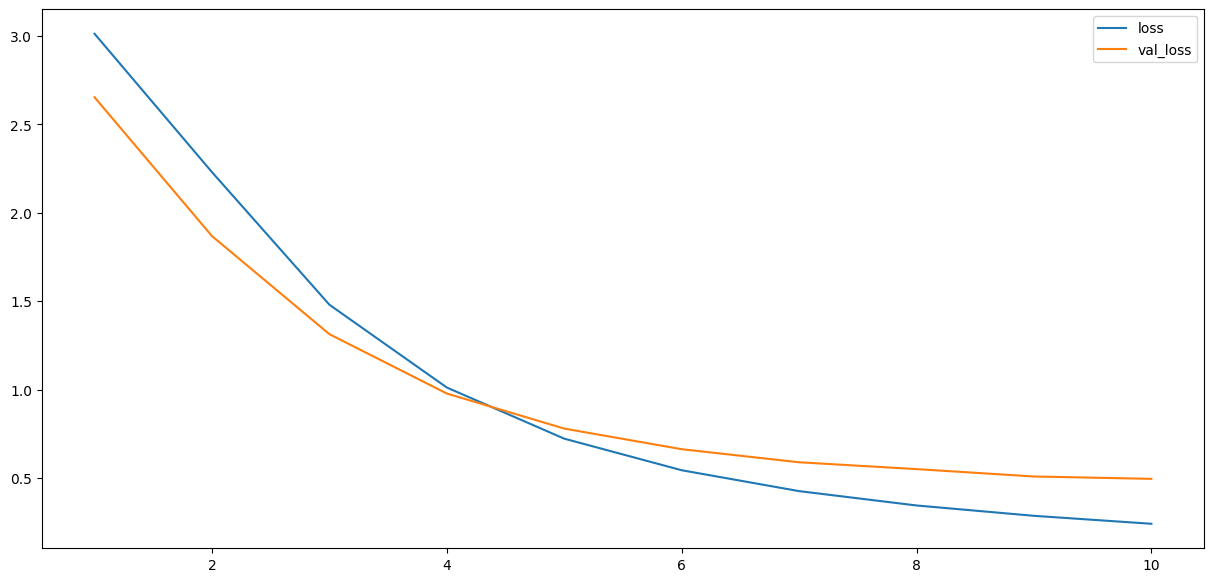

In [ ]:
n_epocs = 10
x = np.arange(1, n_epocs+1)

plt.figure(figsize=(15,7))

plt.plot(x, hist.history['loss'])
plt.plot(x, hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])

plt.show()

In [ ]:
hist = model2.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
62/62 [==============================] - 43s 512ms/step - loss: 2.8272 - val_loss: 2.1613
Epoch 2/10
62/62 [==============================] - 29s 470ms/step - loss: 1.5121 - val_loss: 1.1774
Epoch 3/10
62/62 [==============================] - 29s 470ms/step - loss: 0.8301 - val_loss: 0.8298
Epoch 4/10
62/62 [==============================] - 29s 467ms/step - loss: 0.5561 - val_loss: 0.6594
Epoch 5/10
62/62 [==============================] - 29s 468ms/step - loss: 0.4136 - val_loss: 0.5818
Epoch 6/10
62/62 [==============================] - 29s 466ms/step - loss: 0.3271 - val_loss: 0.5243
Epoch 7/10
62/62 [==============================] - 28s 456ms/step - loss: 0.2644 - val_loss: 0.4845
Epoch 8/10
62/62 [==============================] - 28s 449ms/step - loss: 0.2178 - val_loss: 0.4756
Epoch 9/10
62/62 [==============================] - 28s 454ms/step - loss: 0.1818 - val_loss: 0.4516
Epoch 10/10
62/62 [==============================] - 29s 469ms/step - loss: 0.1525 - val_lo

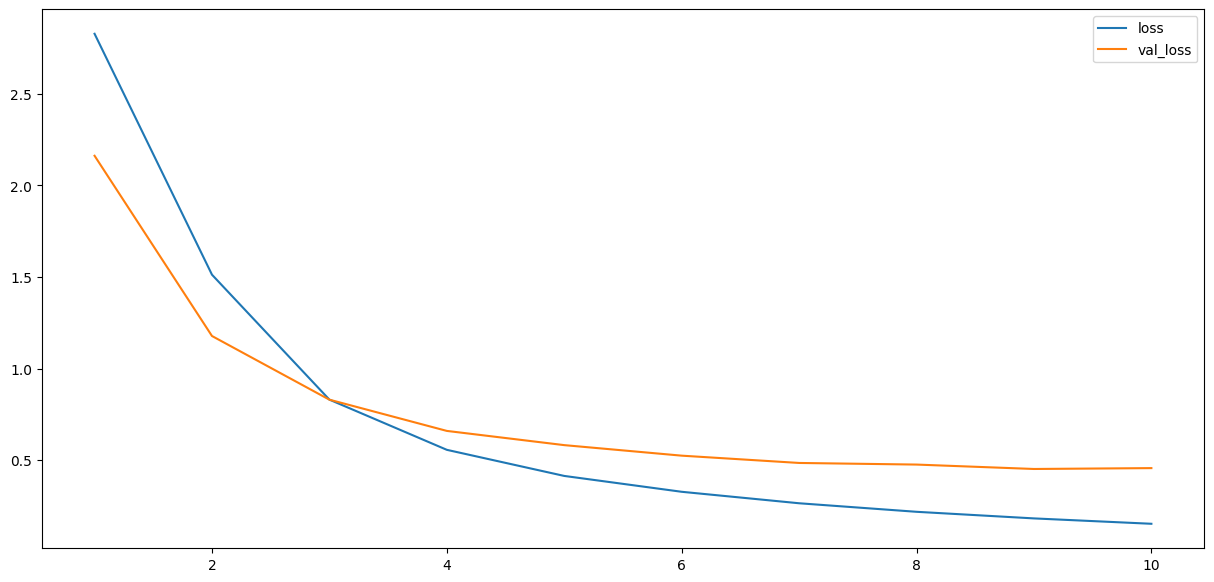

In [ ]:
n_epocs = 10
x = np.arange(1, n_epocs+1)

plt.figure(figsize=(15,7))

plt.plot(x, hist.history['loss'])
plt.plot(x, hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])

plt.show()

In [ ]:
print("Model Baseline")
print_metric(model0, X_valid, y_valid)
print("-"*20)
print("Model 1")
print_metric(model1, X_valid, y_valid)
print("-"*20)
print("Model 2")
print_metric(model2, X_valid, y_valid)

Model Baseline
41/41 [==============================] - 8s 98ms/step
F1 on passed set : 0.758804979965132
--------------------
Model 1
41/41 [==============================] - 11s 165ms/step
F1 on passed set : 0.7501622762494715
--------------------
Model 2
41/41 [==============================] - 8s 131ms/step
F1 on passed set : 0.760845488764656


# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

## Evaluation on test set

In [ ]:
print("Model 2")
print_metric(model2, X_test, y_test)

Model 2
21/21 [==============================] - 3s 123ms/step
F1 on passed set : 0.7947982138651803


## Error comparison

In [ ]:
# Generate random index for samples
samples = [random.randint(0, X_test.shape[0]-1) for i in range(10)]
print(f"Generated random indices: {samples}")
print()

# F1-Score on one random sample
print("Metric over the generated dataset: ")
print_metric(model2, X_test[samples], y_test[samples])
print()

# Perform inference over the selected samples
y_pred_test = model2.predict(X_test[samples])

# Get each tag with the maximum probability
y_pred_class = tf.cast(tf.math.argmax(y_pred_test, axis=-1),"int32")
mask = tf.cast(tf.math.not_equal(y_test[samples], 0), 'int32')

# Reverse the preprocessing
y_true_masked = (tf.cast(y_test[samples], 'int32') * mask).numpy()
y_true_unpadded = np.array([row[row != 0] for row in y_true_masked])
y_true_tags = np.array([remove_punctuation(sequence)[0] for sequence in y_true_unpadded])

y_pred_masked = (tf.cast(y_pred_class,'int32') * mask).numpy()
y_pred_unpadded = np.array([row[row != 0] for row in y_pred_masked])
y_pred_tags = np.array([remove_punctuation(sequence)[0] for sequence in y_pred_unpadded])

print()
print("True tags:")
print(y_pred_tags[0])
print("Predicted tags:")
print(y_true_tags[0])

Generated random indices: [296, 85, 17, 606, 314, 433, 388, 542, 366, 133]

Metric over the generated dataset: 
1/1 [==============================] - 0s 75ms/step
F1 on passed set : 0.8196157927040281

1/1 [==============================] - 0s 74ms/step

True tags:
['NNP' 'POS' 'NN' 'NNP' 'VBD' 'DT' 'NN' 'POS' 'NN' 'VBD' 'VBN' 'CC' 'DT'
 'NN' 'VBD' 'VBG' 'RB']
Predicted tags:
['NNP' 'POS' 'NNP' 'NNP' 'VBD' 'DT' 'NN' 'POS' 'NN' 'VBD' 'VBN' 'CC' 'DT'
 'NN' 'VBD' 'VBG' 'RB']


<ipython-input-42-b2a2f6965a75>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true_unpadded = np.array([row[row != 0] for row in y_true_masked])
<ipython-input-42-b2a2f6965a75>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true_tags = np.array([remove_punctuation(sequence)[0] for sequence in y_true_unpadded])
<ipython-input-42-b2a2f6965a75>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to

In [ ]:
for (i, idx) in enumerate(samples):
  print(f"SAMPLE {idx}")
  print("-------------------------------------------------------")
  print(f"Sentence: {dataset['test']['sequence'].to_numpy()[idx]}")
  print(f"True tags: {y_true_tags[i]}")
  print(f"Predicted tags: {y_pred_tags[i]}")
  print()

SAMPLE 296
-------------------------------------------------------
Sentence: ['mexico', "'s", 'president', 'salinas', 'said', 'the', 'country', "'s", 'recession', 'had', 'ended', 'and', 'the', 'economy', 'was', 'growing', 'again', '.']
True tags: ['NNP' 'POS' 'NNP' 'NNP' 'VBD' 'DT' 'NN' 'POS' 'NN' 'VBD' 'VBN' 'CC' 'DT'
 'NN' 'VBD' 'VBG' 'RB']
Predicted tags: ['NNP' 'POS' 'NN' 'NNP' 'VBD' 'DT' 'NN' 'POS' 'NN' 'VBD' 'VBN' 'CC' 'DT'
 'NN' 'VBD' 'VBG' 'RB']

SAMPLE 85
-------------------------------------------------------
Sentence: ['the', 'soviets', 'are', 'widely', 'believed', 'to', 'need', 'additional', 'supplies', ',', 'despite', 'running', 'up', 'record', 'one-month', 'purchases', 'of', '310', 'million', 'bushels', 'of', 'corn', 'in', 'october', '.']
True tags: ['DT' 'NNPS' 'VBP' 'RB' 'VBN' 'TO' 'VB' 'JJ' 'NNS' 'IN' 'VBG' 'RP' 'JJ'
 'JJ' 'NNS' 'IN' 'CD' 'CD' 'NNS' 'IN' 'NN' 'IN' 'NNP']
Predicted tags: ['DT' 'NNS' 'VBP' 'RB' 'VBN' 'TO' 'VB' 'JJ' 'NNS' 'IN' 'VBG' 'IN' 'JJ'
 'JJ' 'NNS' 

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay

def compute_MCM(y_true, y_pred):
  y_pred_class = tf.cast(tf.math.argmax(y_pred, axis=-1),"int32")
  mask = tf.cast(tf.math.not_equal(y_true, 0), 'int32')
  #print(y_pred_class*mask)
  #y_pred_unpadded,indexes_pred_unpadded = np.array(remove_punctuation(remove_padding(y_pred_class * mask)))
  y_true_unpadded,removed_indexes= remove_punctuation(remove_padding(tf.cast(y_true,'int32') * mask))
  #Remove indexes punctuations tokens in y_pred
  y_pred_unpadded = reverse_vectorization_tags(remove_padding(y_pred_class * mask).numpy())
  y_pred_unpadded= np.delete(y_pred_unpadded,removed_indexes)

  mcm = multilabel_confusion_matrix(y_true_unpadded, y_pred_unpadded, labels=POS_TAGS)
  cm = confusion_matrix(y_true_unpadded, y_pred_unpadded, labels=POS_TAGS)
  cr = classification_report(y_true_unpadded, y_pred_unpadded, labels=POS_TAGS, target_names=POS_TAGS, digits=4, zero_division=0)

  return mcm, cm, cr

print("\n PER-TAG CONFUSION MATRIX: \n")
def print_MCM(model, features, labels):
  predictions = model.predict(features)
  mcm, cm, cr = compute_MCM(labels, predictions)

  for (i, tag) in enumerate(POS_TAGS):
    print(f"\n[{tag}] Confusion Matrix: \n {mcm[i]}")

  print("\n CLASSIFICATION REPORT: \n")
  print(cr)

  print("\n COMPLETE CONFUSION MATRIX: \n")
  disp = ConfusionMatrixDisplay(cm, display_labels=POS_TAGS)
  fig, ax = plt.subplots(figsize=(20,20))
  disp.plot(ax=ax)

21/21 [==============================] - 2s 83ms/step

[PAD] Confusion Matrix: 
 [[13712     0]
 [    0     0]]

[#] Confusion Matrix: 
 [[13712     0]
 [    0     0]]

[$] Confusion Matrix: 
 [[13712     0]
 [    0     0]]

[''] Confusion Matrix: 
 [[13712     0]
 [    0     0]]

[,] Confusion Matrix: 
 [[13712     0]
 [    0     0]]

[-LRB-] Confusion Matrix: 
 [[13694    18]
 [    0     0]]

[-RRB-] Confusion Matrix: 
 [[13696    16]
 [    0     0]]

[.] Confusion Matrix: 
 [[13712     0]
 [    0     0]]

[:] Confusion Matrix: 
 [[13711     1]
 [    0     0]]

[CC] Confusion Matrix: 
 [[13345     1]
 [    1   365]]

[CD] Confusion Matrix: 
 [[12842    12]
 [  146   712]]

[DT] Confusion Matrix: 
 [[12362    15]
 [   11  1324]]

[EX] Confusion Matrix: 
 [[13706     1]
 [    0     5]]

[FW] Confusion Matrix: 
 [[13712     0]
 [    0     0]]

[IN] Confusion Matrix: 
 [[12046    36]
 [   45  1585]]

[JJ] Confusion Matrix: 
 [[12517   277]
 [  231   687]]

[JJR] Confusion Matrix: 
 [[136

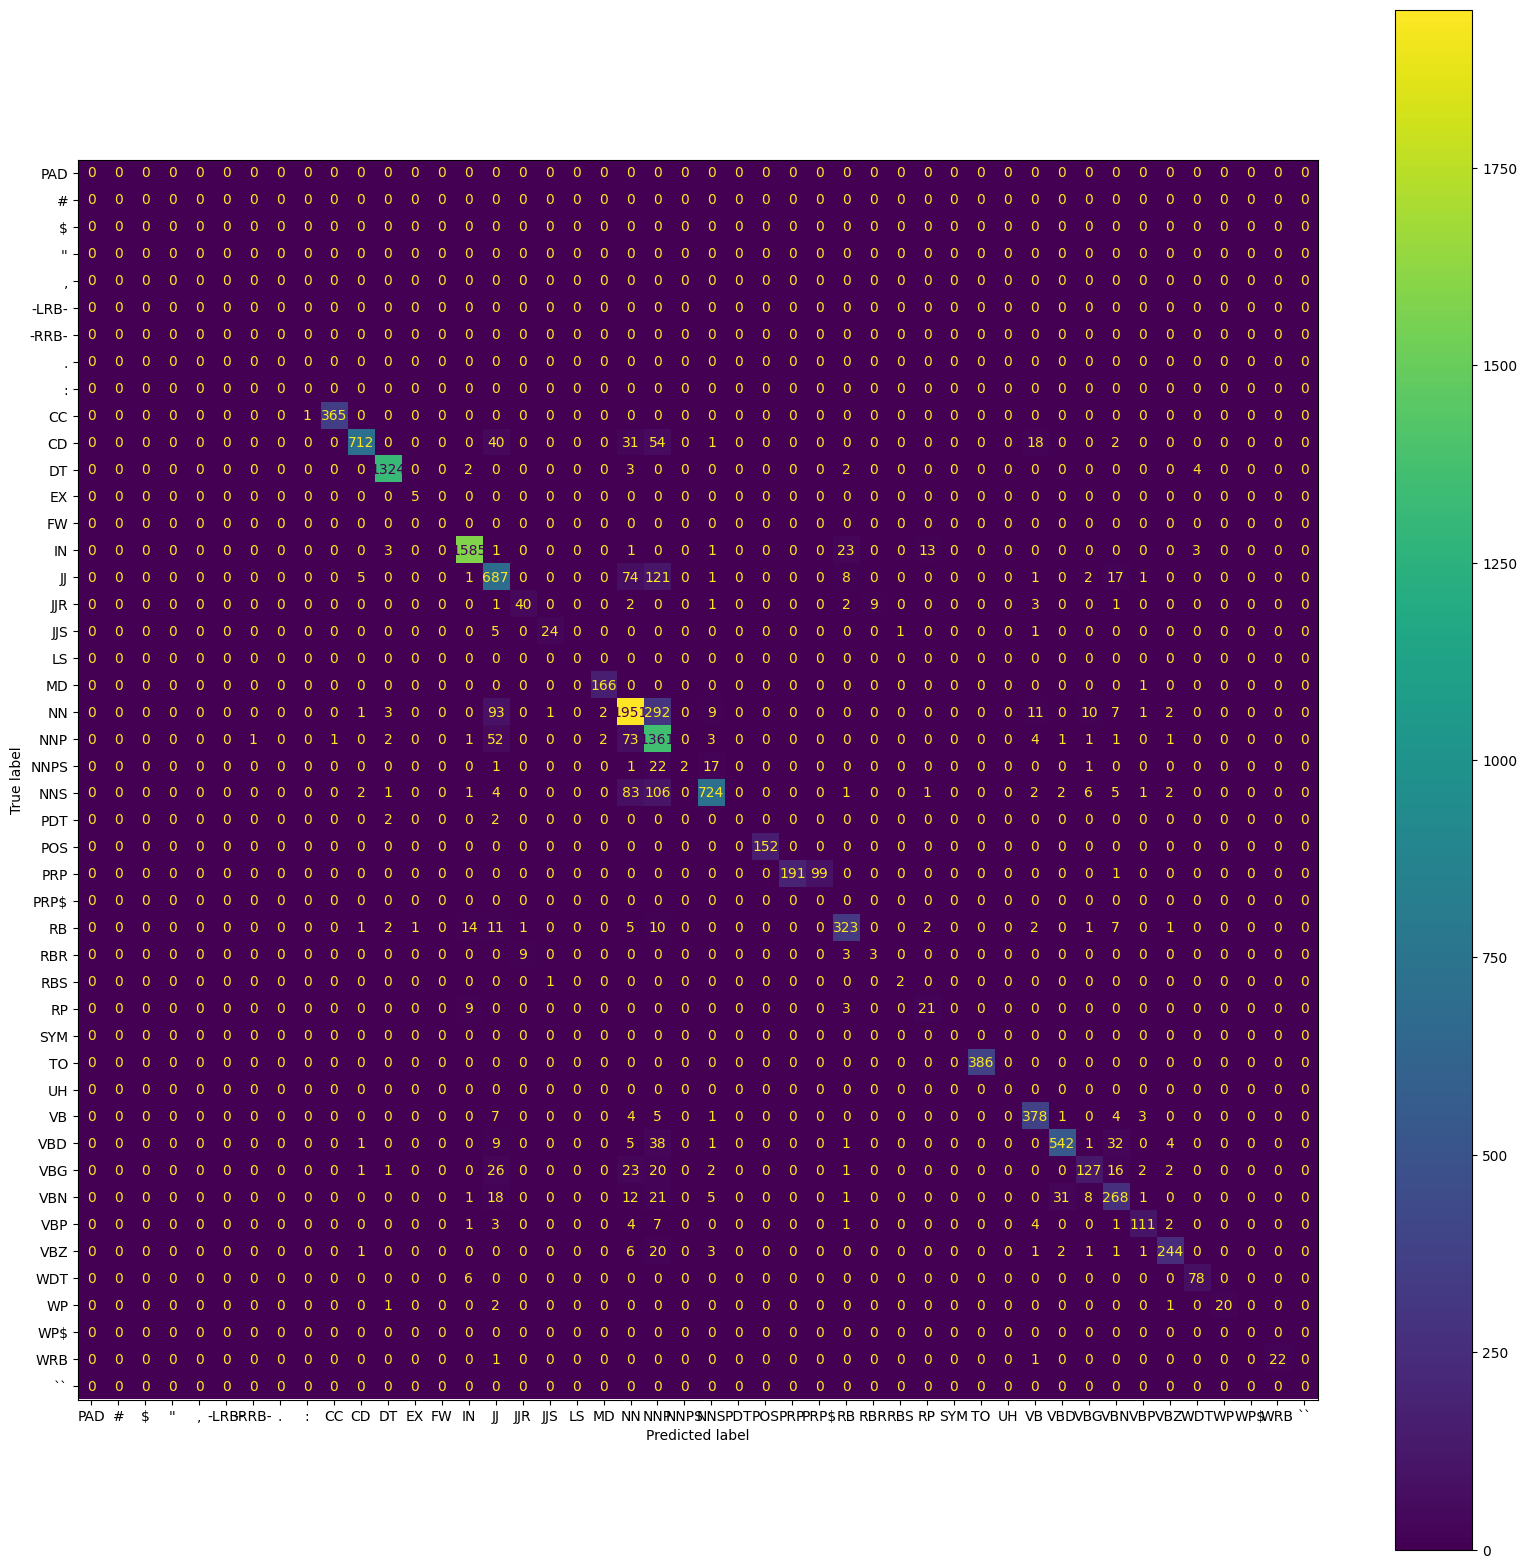

In [ ]:
print_MCM(model2, X_test, y_test)

41/41 [==============================] - 3s 82ms/step

[PAD] Confusion Matrix: 
 [[27521     0]
 [    0     0]]

[#] Confusion Matrix: 
 [[27521     0]
 [    0     0]]

[$] Confusion Matrix: 
 [[27521     0]
 [    0     0]]

[''] Confusion Matrix: 
 [[27521     0]
 [    0     0]]

[,] Confusion Matrix: 
 [[27520     1]
 [    0     0]]

[-LRB-] Confusion Matrix: 
 [[27472    49]
 [    0     0]]

[-RRB-] Confusion Matrix: 
 [[27458    63]
 [    0     0]]

[.] Confusion Matrix: 
 [[27521     0]
 [    0     0]]

[:] Confusion Matrix: 
 [[27521     0]
 [    0     0]]

[CC] Confusion Matrix: 
 [[26762     1]
 [   10   748]]

[CD] Confusion Matrix: 
 [[26256    16]
 [  271   978]]

[DT] Confusion Matrix: 
 [[24731    36]
 [   16  2738]]

[EX] Confusion Matrix: 
 [[27484     3]
 [    0    34]]

[FW] Confusion Matrix: 
 [[27519     0]
 [    2     0]]

[IN] Confusion Matrix: 
 [[24179    67]
 [   80  3195]]

[JJ] Confusion Matrix: 
 [[25030   567]
 [  473  1451]]

[JJR] Confusion Matrix: 
 [[273

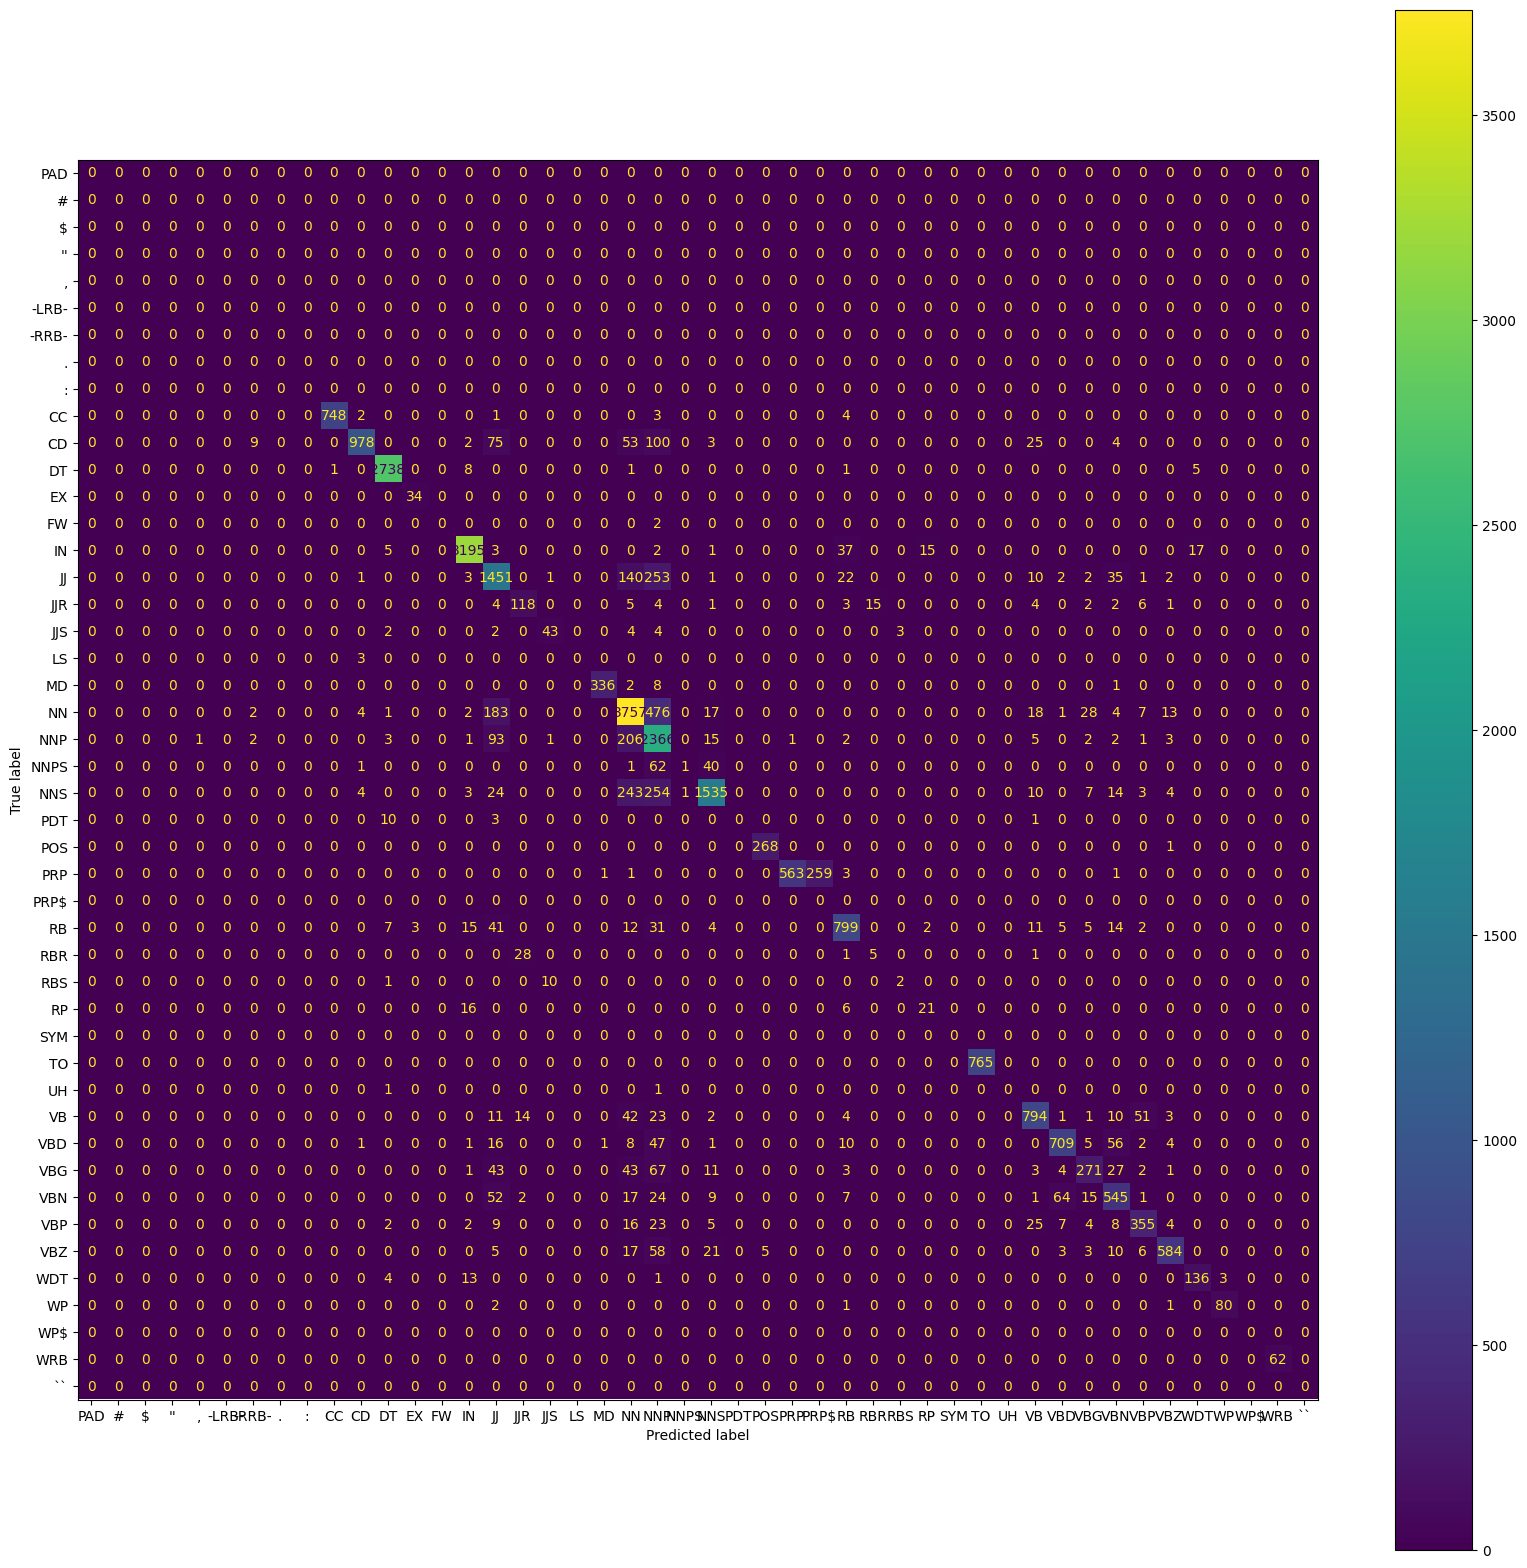

In [ ]:
print_MCM(model2, X_valid, y_valid)

**Error Categories**

Given the results above we can classify our errors in different categories:

**Adverbs**

Comparative/Superlative adverbs are most of the times confused with comparative/superlative adjectives.

\[RBR]: 'more'

```
SAMPLE 84
-------------------------------------------------------
Sentence:       ['that', 'designation', 'would', ',', 'among', 'other', 'things', ',', 'provide', 'more', 'generous', 'credit', 'terms', 'under', 'which', 'the', 'soviets', 'could', 'purchase', 'grain', '.']
True tags:      ['DT' 'NN' 'MD' 'IN' 'JJ' 'NNS' 'VB' 'RBR' 'JJ' 'NN' 'NNS' 'IN' 'WDT' 'DT' 'NNPS' 'MD' 'VB' 'NN']
Predicted tags: ['DT' 'NNP' 'MD' 'IN' 'JJ' 'NNS' 'VBP' 'JJR' 'JJ' 'NN' 'NNS' 'IN' 'WDT' 'DT' 'NNS' 'MD' 'VB' 'NN']
```

**Particles**

Particles (as for phrasal verbs) are most of the times confused with prepositions.

\[RP]: 'down' (write down)

```
 SAMPLE 378
-------------------------------------------------------
Sentence:       ['new', 'rules', 'force', 'thrifts', 'to', 'write', 'down', 'their', 'junk', 'to', 'market', 'value', ',', 'then', 'sell', 'the', 'bonds', 'over', 'five', 'years', '.']
True tags:      ['JJ' 'NNS' 'VBP' 'NNS' 'TO' 'VB' 'RP' 'PRP' 'NN' 'TO' 'NN' 'NN' 'RB' 'VB' 'DT' 'NNS' 'IN' 'CD' 'NNS']
Predicted tags: ['NNP' 'NNS' 'NNP' 'NNS' 'TO' 'VB' 'IN' 'PRP' 'NN' 'TO' 'NN' 'NN' 'RB' 'VB' 'DT' 'NNS' 'IN' 'CD' 'NNS']
```

**Nouns**

Nouns, namely proper nouns, are confused many times.

\[NNS]: 'conferees'
\[NNS]: 'portions'

```
SAMPLE 287
-------------------------------------------------------
Sentence:       ['house-senate', 'conferees', 'approved', 'major', 'portions', 'of', 'a', 'package', 'for', 'more', 'than', '$', '500', 'million', 'in', 'economic', 'aid', 'for', 'poland', '.']
True tags:      ['NNP' 'NNS' 'VBD' 'JJ' 'NNS' 'IN' 'DT' 'NN' 'IN' 'RBR' 'IN' 'CD' 'CD' 'IN' 'JJ' 'NN' 'IN' 'NNP']
Predicted tags: ['NNP' 'NNP' 'VBD' 'JJ' 'NN' 'IN' 'DT' 'NN' 'IN' 'JJR' 'IN' 'CD' 'CD' 'IN' 'JJ' 'NN' 'IN' 'NNP']
```

**Verbs**

Due to their nature, some verb tenses can be used as nouns or adjectives, therefore they are some times confused.

\[VBN]: 'specialized'

```
SAMPLE 426
-------------------------------------------------------
Sentence:       ['metallgesellschaft', ',', 'a', 'diversified', 'frankfurt', ',', 'west', 'germany-based', 'metals', 'group', ',', 'said', 'it', 'is', 'buying', 'the', 'stake', 'in', 'the', 'specialized', 'engineering', 'company', 'to', 'expand', 'its', 'production', 'of', 'environmental', 'supplies', 'for', 'power', 'plants', '.']
True tags:      ['NN' 'DT' 'JJ' 'NNP' 'NNP' 'JJ' 'NNS' 'NN' 'VBD' 'PRP' 'VBZ' 'VBG' 'DT' 'NN' 'IN' 'DT' 'VBN' 'NN' 'NN' 'TO' 'VB' 'PRP' 'NN' 'IN' 'JJ' 'NNS' 'IN' 'NN' 'NNS']
Predicted tags: ['NNP' 'DT' 'JJ' 'NNP' 'NNP' 'NNP' 'NNS' 'NNP' 'VBD' 'PRP' 'VBZ' 'VBG' 'DT' 'NN' 'IN' 'DT' 'NNP' 'NN' 'NN' 'TO' 'VB' 'PRP' 'NN' 'IN' 'NNP' 'VBD' 'IN' 'NN' 'NNS']
```
---
**Possible Solutions**

Most of the errors are solved with a bigger dataset. Since the amount of total RBR and RBS is really small, probably the model was not able to learn the difference between these ones and the JJR and JJS.
Other problems like for the proper nouns could be partially resolved removing the lowercasing we performed on the preprocessing step. Most of the proper nouns are distinguished thanks to the capital letters and therefore they might be crucial for their differentiation.
A pre-trained embedding with bigger vocabulary could also solve some of these problems, unfortunately most of the times bigger datasets and pretrained embedding are resources that are unavailable for us.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End